In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
hn = 5
class Model(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.hidden = torch.zeros((1, hn))
        self.stepLength = 1.2
        
        #RNN
        self.Whh = nn.Linear(hn, hn)
        self.Whx = nn.Linear(1, hn, bias = False)
        self.Why = nn.Linear(hn, 1)
        
        #DNN
        self.layer1 = nn.Linear(1, 16)
        self.layer2 = nn.Linear(16, 4)
        self.layer3 = nn.Linear(4, 1)
        

    def forward_RNN(self, x):
        
        self.hidden = torch.tanh(self.Whh(self.hidden) + self.Whx(x))
    

    def forward_DNN(self, x):
        
        y = self.Why(self.hidden.repeat((x.shape[0], 1)))
        
        #X = torch.cat((x, y), 1)
        X = torch.tanh(self.layer1(x))
        X = torch.tanh(self.layer2(X))
        X = self.layer3(X)

        
        return X*torch.exp(-0.5*x**2)

    def sample(self):
        total = 0
        x = torch.Tensor((2*np.random.random((1, 1)) - 1))
        psi_old = self.forward_DNN(x)

        for i in range(20):
            x_new = x + self.stepLength*torch.Tensor((2*np.random.random((1, 1)) - 1))
            psi_new = model.forward_DNN(x_new)

            if (psi_new/psi_old)**2 > np.random.random():
                x = x_new
                psi_old = psi_new
                total += 1
        
        x = x.detach()
           
        return x, total
    
    def resetHidden(self):
        self.hidden = torch.zeros((1, hn))
        

In [3]:
torch.manual_seed(42)
np.random.seed(42)
model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)


#print(list(model.parameters()))

In [4]:
epochs = 1000
N = 50
for epoch in tqdm(range(epochs)):
    P_acc = 0
    E_acc = 0
    PE_acc = 0
    grad = 0

    for i in range(N):
        psi_total = 1
        
        model.resetHidden()
        x1 = model.sample()[0]
        x1_ = x1.detach().requires_grad_()
        
        psi = model.forward_DNN(x1_)
        dfdx, = torch.autograd.grad(psi, x1_, create_graph=True)
        d2fdx2, = torch.autograd.grad(dfdx, x1_, create_graph=True)
        
        lap1 = 1/psi*d2fdx2.grad_fn(x1_)[1]
        pot1 = 0.5*x1**2
        psi_total *= psi

        #model.forward_RNN(x1)
        #x2 = model.sample()[0]
        #x2_ = x2.detach().requires_grad_()
        
        #psi = model.forward_DNN(x2_)
        #dfdx, = torch.autograd.grad(psi, x2_, create_graph=True)
        #d2fdx2, = torch.autograd.grad(dfdx, x2_, create_graph=True)
        
        #lap2 = 1/psi*d2fdx2.grad_fn(x2_)[1]
        #pot2 = 0.5*x2**2
        #psi_total *= psi
        
        #E_L = (-0.5*(lap1 + lap2) + pot1 + pot2).detach()
        E_L = (-0.5*(lap1) + pot1).detach()
        E_acc  += E_L
        PE_acc += psi_total/(psi_total.detach())*E_L
        P_acc  += psi_total/(psi_total.detach())
        
    E_acc  /= N
    PE_acc /= N
    P_acc  /= N
    
    E = 2*(PE_acc - P_acc*E_acc)
    
    optimizer.zero_grad()
    E.backward()
    optimizer.step()
    
    for param in model.parameters():
        try:
            grad += torch.sum(param.grad**2)
        except:
            pass
    
    grad = torch.sqrt(grad)
    
    if (epoch%10 == 0):
        print(f"epoch: {epoch}, L2-norm of gradient: {grad}, L2-norm of gradient: {E_acc}")

  0%|          | 1/1000 [00:00<03:52,  4.31it/s]

epoch: 0, L2-norm of gradient: 17.863990783691406, L2-norm of gradient: tensor([[-0.7258]])


  1%|          | 11/1000 [00:02<03:20,  4.93it/s]

epoch: 10, L2-norm of gradient: 13.227448463439941, L2-norm of gradient: tensor([[-1.9583]])


  2%|▏         | 22/1000 [00:04<03:04,  5.31it/s]

epoch: 20, L2-norm of gradient: 10.050806999206543, L2-norm of gradient: tensor([[-0.6118]])


  3%|▎         | 32/1000 [00:06<02:59,  5.38it/s]

epoch: 30, L2-norm of gradient: 11.614012718200684, L2-norm of gradient: tensor([[-1.0036]])


  4%|▍         | 42/1000 [00:08<03:00,  5.31it/s]

epoch: 40, L2-norm of gradient: 15.464585304260254, L2-norm of gradient: tensor([[-1.4995]])


  5%|▌         | 52/1000 [00:10<03:03,  5.18it/s]

epoch: 50, L2-norm of gradient: 14.515748977661133, L2-norm of gradient: tensor([[-2.2510]])


  6%|▌         | 62/1000 [00:11<02:58,  5.26it/s]

epoch: 60, L2-norm of gradient: 42.27482223510742, L2-norm of gradient: tensor([[-2.3062]])


  7%|▋         | 72/1000 [00:13<02:57,  5.23it/s]

epoch: 70, L2-norm of gradient: 12.626391410827637, L2-norm of gradient: tensor([[-2.5783]])


  8%|▊         | 82/1000 [00:15<02:57,  5.17it/s]

epoch: 80, L2-norm of gradient: 18.535207748413086, L2-norm of gradient: tensor([[-3.1294]])


  9%|▉         | 92/1000 [00:17<02:54,  5.19it/s]

epoch: 90, L2-norm of gradient: 2.2340188026428223, L2-norm of gradient: tensor([[-3.9192]])


 10%|█         | 102/1000 [00:19<02:53,  5.17it/s]

epoch: 100, L2-norm of gradient: 4.422989368438721, L2-norm of gradient: tensor([[-3.9851]])


 11%|█         | 112/1000 [00:21<02:57,  5.00it/s]

epoch: 110, L2-norm of gradient: 7.218674659729004, L2-norm of gradient: tensor([[-3.7950]])


 12%|█▏        | 122/1000 [00:23<02:47,  5.25it/s]

epoch: 120, L2-norm of gradient: 7.340940952301025, L2-norm of gradient: tensor([[-4.3192]])


 13%|█▎        | 132/1000 [00:25<02:46,  5.22it/s]

epoch: 130, L2-norm of gradient: 3.597301721572876, L2-norm of gradient: tensor([[-3.9633]])


 14%|█▍        | 142/1000 [00:27<02:44,  5.22it/s]

epoch: 140, L2-norm of gradient: 7.892820358276367, L2-norm of gradient: tensor([[-2.9997]])


 15%|█▌        | 152/1000 [00:29<02:41,  5.25it/s]

epoch: 150, L2-norm of gradient: 11.11611270904541, L2-norm of gradient: tensor([[-6.2111]])


 16%|█▌        | 162/1000 [00:31<02:41,  5.19it/s]

epoch: 160, L2-norm of gradient: 3.304328203201294, L2-norm of gradient: tensor([[-3.8645]])


 17%|█▋        | 172/1000 [00:33<02:39,  5.20it/s]

epoch: 170, L2-norm of gradient: 6.3271870613098145, L2-norm of gradient: tensor([[-4.0557]])


 18%|█▊        | 181/1000 [00:35<02:41,  5.07it/s]

epoch: 180, L2-norm of gradient: 5.545813083648682, L2-norm of gradient: tensor([[-4.0446]])


 19%|█▉        | 192/1000 [00:37<02:36,  5.16it/s]

epoch: 190, L2-norm of gradient: 47.076576232910156, L2-norm of gradient: tensor([[-13.2715]])


 20%|██        | 201/1000 [00:38<02:38,  5.04it/s]

epoch: 200, L2-norm of gradient: 30.268373489379883, L2-norm of gradient: tensor([[-7.6204]])


 21%|██        | 212/1000 [00:41<02:35,  5.07it/s]

epoch: 210, L2-norm of gradient: 11.725126266479492, L2-norm of gradient: tensor([[-7.1746]])


 22%|██▏       | 222/1000 [00:43<02:32,  5.10it/s]

epoch: 220, L2-norm of gradient: 7.637379169464111, L2-norm of gradient: tensor([[-3.4822]])


 23%|██▎       | 232/1000 [00:44<02:25,  5.28it/s]

epoch: 230, L2-norm of gradient: 17.859272003173828, L2-norm of gradient: tensor([[-3.4754]])


 24%|██▍       | 242/1000 [00:46<02:22,  5.32it/s]

epoch: 240, L2-norm of gradient: 3.1497836112976074, L2-norm of gradient: tensor([[-2.8684]])


 25%|██▌       | 252/1000 [00:48<02:21,  5.27it/s]

epoch: 250, L2-norm of gradient: 4.337399482727051, L2-norm of gradient: tensor([[-4.6821]])


 26%|██▌       | 262/1000 [00:50<02:24,  5.10it/s]

epoch: 260, L2-norm of gradient: 2.5818521976470947, L2-norm of gradient: tensor([[-3.6656]])


 27%|██▋       | 271/1000 [00:52<02:27,  4.96it/s]

epoch: 270, L2-norm of gradient: 2.818889617919922, L2-norm of gradient: tensor([[-3.2781]])


 28%|██▊       | 281/1000 [00:54<02:19,  5.16it/s]

epoch: 280, L2-norm of gradient: 2.3679089546203613, L2-norm of gradient: tensor([[-3.1001]])


 29%|██▉       | 292/1000 [00:56<02:19,  5.08it/s]

epoch: 290, L2-norm of gradient: 6.719094753265381, L2-norm of gradient: tensor([[-3.7721]])


 30%|███       | 302/1000 [00:58<02:16,  5.12it/s]

epoch: 300, L2-norm of gradient: 3.9773199558258057, L2-norm of gradient: tensor([[-3.7417]])


 31%|███       | 312/1000 [01:00<02:10,  5.28it/s]

epoch: 310, L2-norm of gradient: 12.583723068237305, L2-norm of gradient: tensor([[-4.0942]])


 32%|███▏      | 321/1000 [01:02<02:16,  4.97it/s]

epoch: 320, L2-norm of gradient: 5.110087871551514, L2-norm of gradient: tensor([[-3.5196]])


 33%|███▎      | 331/1000 [01:04<02:17,  4.86it/s]

epoch: 330, L2-norm of gradient: 2.3095273971557617, L2-norm of gradient: tensor([[-3.5106]])


 34%|███▍      | 342/1000 [01:06<02:05,  5.26it/s]

epoch: 340, L2-norm of gradient: 1.4984883069992065, L2-norm of gradient: tensor([[-3.6782]])


 35%|███▌      | 352/1000 [01:08<02:03,  5.24it/s]

epoch: 350, L2-norm of gradient: 21.881179809570312, L2-norm of gradient: tensor([[-6.5781]])


 36%|███▌      | 362/1000 [01:10<02:01,  5.27it/s]

epoch: 360, L2-norm of gradient: 8.708208084106445, L2-norm of gradient: tensor([[-3.8437]])


 37%|███▋      | 372/1000 [01:12<01:58,  5.31it/s]

epoch: 370, L2-norm of gradient: 8.615843772888184, L2-norm of gradient: tensor([[-5.0733]])


 38%|███▊      | 382/1000 [01:14<01:58,  5.23it/s]

epoch: 380, L2-norm of gradient: 1.9464397430419922, L2-norm of gradient: tensor([[-3.9489]])


 39%|███▉      | 392/1000 [01:16<01:57,  5.19it/s]

epoch: 390, L2-norm of gradient: 11.839956283569336, L2-norm of gradient: tensor([[-3.7206]])


 40%|████      | 402/1000 [01:17<01:50,  5.42it/s]

epoch: 400, L2-norm of gradient: 1.2232617139816284, L2-norm of gradient: tensor([[-3.2634]])


 41%|████      | 412/1000 [01:19<01:50,  5.32it/s]

epoch: 410, L2-norm of gradient: 6.9582648277282715, L2-norm of gradient: tensor([[-3.8171]])


 42%|████▏     | 422/1000 [01:21<01:49,  5.26it/s]

epoch: 420, L2-norm of gradient: 11.49394702911377, L2-norm of gradient: tensor([[-3.3433]])


 43%|████▎     | 432/1000 [01:23<01:47,  5.29it/s]

epoch: 430, L2-norm of gradient: 2.5001120567321777, L2-norm of gradient: tensor([[-3.7973]])


 44%|████▍     | 442/1000 [01:25<01:45,  5.27it/s]

epoch: 440, L2-norm of gradient: 8.556519508361816, L2-norm of gradient: tensor([[-4.2932]])


 45%|████▌     | 452/1000 [01:27<01:41,  5.40it/s]

epoch: 450, L2-norm of gradient: 2.822413921356201, L2-norm of gradient: tensor([[-4.5107]])


 46%|████▌     | 462/1000 [01:29<01:43,  5.20it/s]

epoch: 460, L2-norm of gradient: 12.192919731140137, L2-norm of gradient: tensor([[-3.7289]])


 47%|████▋     | 472/1000 [01:31<01:40,  5.24it/s]

epoch: 470, L2-norm of gradient: 1.3338253498077393, L2-norm of gradient: tensor([[-3.5003]])


 48%|████▊     | 482/1000 [01:33<01:37,  5.31it/s]

epoch: 480, L2-norm of gradient: 4.256536483764648, L2-norm of gradient: tensor([[-3.8530]])


 49%|████▉     | 492/1000 [01:35<01:36,  5.26it/s]

epoch: 490, L2-norm of gradient: 3.2404274940490723, L2-norm of gradient: tensor([[-4.0708]])


 50%|█████     | 502/1000 [01:37<01:34,  5.28it/s]

epoch: 500, L2-norm of gradient: 1.9981210231781006, L2-norm of gradient: tensor([[-2.9686]])


 51%|█████     | 512/1000 [01:38<01:35,  5.09it/s]

epoch: 510, L2-norm of gradient: 5.717190742492676, L2-norm of gradient: tensor([[-3.2134]])


 52%|█████▏    | 522/1000 [01:40<01:33,  5.11it/s]

epoch: 520, L2-norm of gradient: 23.088985443115234, L2-norm of gradient: tensor([[-5.9227]])


 53%|█████▎    | 532/1000 [01:42<01:29,  5.22it/s]

epoch: 530, L2-norm of gradient: 4.683748722076416, L2-norm of gradient: tensor([[-3.5843]])


 54%|█████▍    | 542/1000 [01:44<01:28,  5.16it/s]

epoch: 540, L2-norm of gradient: 3.1940743923187256, L2-norm of gradient: tensor([[-3.9107]])


 55%|█████▌    | 552/1000 [01:46<01:27,  5.14it/s]

epoch: 550, L2-norm of gradient: 9.385566711425781, L2-norm of gradient: tensor([[-4.2220]])


 56%|█████▌    | 562/1000 [01:48<01:27,  5.03it/s]

epoch: 560, L2-norm of gradient: 8.07534408569336, L2-norm of gradient: tensor([[-4.8882]])


 57%|█████▋    | 572/1000 [01:50<01:21,  5.28it/s]

epoch: 570, L2-norm of gradient: 6.368744850158691, L2-norm of gradient: tensor([[-3.2011]])


 58%|█████▊    | 582/1000 [01:52<01:20,  5.22it/s]

epoch: 580, L2-norm of gradient: 2.1658668518066406, L2-norm of gradient: tensor([[-4.1694]])


 59%|█████▉    | 592/1000 [01:54<01:17,  5.26it/s]

epoch: 590, L2-norm of gradient: 8.31763744354248, L2-norm of gradient: tensor([[-5.5022]])


 60%|██████    | 602/1000 [01:56<01:17,  5.13it/s]

epoch: 600, L2-norm of gradient: 3.588519811630249, L2-norm of gradient: tensor([[-4.7053]])


 61%|██████    | 612/1000 [01:58<01:16,  5.07it/s]

epoch: 610, L2-norm of gradient: 4.221796989440918, L2-norm of gradient: tensor([[-3.2687]])


 62%|██████▏   | 622/1000 [02:00<01:12,  5.24it/s]

epoch: 620, L2-norm of gradient: 9.793059349060059, L2-norm of gradient: tensor([[-4.7200]])


 63%|██████▎   | 632/1000 [02:02<01:10,  5.22it/s]

epoch: 630, L2-norm of gradient: 2.344212532043457, L2-norm of gradient: tensor([[-3.2189]])


 64%|██████▍   | 642/1000 [02:04<01:07,  5.29it/s]

epoch: 640, L2-norm of gradient: 5.604552268981934, L2-norm of gradient: tensor([[-3.2701]])


 65%|██████▌   | 652/1000 [02:05<01:06,  5.25it/s]

epoch: 650, L2-norm of gradient: 3.9034249782562256, L2-norm of gradient: tensor([[-4.0906]])


 66%|██████▌   | 662/1000 [02:07<01:04,  5.24it/s]

epoch: 660, L2-norm of gradient: 2.5484161376953125, L2-norm of gradient: tensor([[-3.8932]])


 67%|██████▋   | 672/1000 [02:09<01:01,  5.30it/s]

epoch: 670, L2-norm of gradient: 15.56372356414795, L2-norm of gradient: tensor([[-4.4353]])


 68%|██████▊   | 682/1000 [02:11<01:00,  5.22it/s]

epoch: 680, L2-norm of gradient: 9.256147384643555, L2-norm of gradient: tensor([[-4.4127]])


 69%|██████▉   | 692/1000 [02:13<00:59,  5.22it/s]

epoch: 690, L2-norm of gradient: 3.7217400074005127, L2-norm of gradient: tensor([[-3.3276]])


 70%|███████   | 702/1000 [02:15<00:57,  5.20it/s]

epoch: 700, L2-norm of gradient: 4.373945236206055, L2-norm of gradient: tensor([[-3.7393]])


 71%|███████   | 712/1000 [02:17<00:54,  5.24it/s]

epoch: 710, L2-norm of gradient: 1.7405035495758057, L2-norm of gradient: tensor([[-3.7569]])


 72%|███████▏  | 722/1000 [02:19<00:50,  5.49it/s]

epoch: 720, L2-norm of gradient: 8.126947402954102, L2-norm of gradient: tensor([[-4.4094]])


 73%|███████▎  | 732/1000 [02:21<00:51,  5.25it/s]

epoch: 730, L2-norm of gradient: 1.4763474464416504, L2-norm of gradient: tensor([[-3.0677]])


 74%|███████▍  | 742/1000 [02:23<00:49,  5.24it/s]

epoch: 740, L2-norm of gradient: 3.7165234088897705, L2-norm of gradient: tensor([[-4.4947]])


 75%|███████▌  | 752/1000 [02:24<00:47,  5.25it/s]

epoch: 750, L2-norm of gradient: 5.937556743621826, L2-norm of gradient: tensor([[-3.5298]])


 76%|███████▌  | 762/1000 [02:26<00:44,  5.40it/s]

epoch: 760, L2-norm of gradient: 2.898860454559326, L2-norm of gradient: tensor([[-4.1351]])


 77%|███████▋  | 772/1000 [02:28<00:43,  5.24it/s]

epoch: 770, L2-norm of gradient: 8.637657165527344, L2-norm of gradient: tensor([[-6.3713]])


 78%|███████▊  | 782/1000 [02:30<00:41,  5.28it/s]

epoch: 780, L2-norm of gradient: 11.122893333435059, L2-norm of gradient: tensor([[-4.6925]])


 79%|███████▉  | 792/1000 [02:32<00:39,  5.21it/s]

epoch: 790, L2-norm of gradient: 5.084130764007568, L2-norm of gradient: tensor([[-5.1034]])


 80%|████████  | 802/1000 [02:34<00:38,  5.17it/s]

epoch: 800, L2-norm of gradient: 10.296647071838379, L2-norm of gradient: tensor([[-4.8321]])


 81%|████████  | 812/1000 [02:36<00:36,  5.13it/s]

epoch: 810, L2-norm of gradient: 6.962090492248535, L2-norm of gradient: tensor([[-4.2470]])


 82%|████████▏ | 822/1000 [02:38<00:34,  5.15it/s]

epoch: 820, L2-norm of gradient: 7.997623920440674, L2-norm of gradient: tensor([[-4.0197]])


 83%|████████▎ | 831/1000 [02:40<00:33,  5.12it/s]

epoch: 830, L2-norm of gradient: 10.58332633972168, L2-norm of gradient: tensor([[-3.3593]])


 84%|████████▍ | 842/1000 [02:42<00:30,  5.13it/s]

epoch: 840, L2-norm of gradient: 8.002115249633789, L2-norm of gradient: tensor([[-4.0038]])


 85%|████████▌ | 851/1000 [02:43<00:29,  5.12it/s]

epoch: 850, L2-norm of gradient: 9.228958129882812, L2-norm of gradient: tensor([[-3.8437]])


 86%|████████▌ | 862/1000 [02:46<00:26,  5.21it/s]

epoch: 860, L2-norm of gradient: 10.05731201171875, L2-norm of gradient: tensor([[-3.8168]])


 87%|████████▋ | 872/1000 [02:48<00:24,  5.13it/s]

epoch: 870, L2-norm of gradient: 3.7522315979003906, L2-norm of gradient: tensor([[-4.8273]])


 88%|████████▊ | 882/1000 [02:50<00:23,  5.11it/s]

epoch: 880, L2-norm of gradient: 12.507457733154297, L2-norm of gradient: tensor([[-5.3434]])


 89%|████████▉ | 892/1000 [02:52<00:21,  5.10it/s]

epoch: 890, L2-norm of gradient: 54.511558532714844, L2-norm of gradient: tensor([[-7.6641]])


 90%|█████████ | 902/1000 [02:53<00:19,  5.12it/s]

epoch: 900, L2-norm of gradient: 8.742623329162598, L2-norm of gradient: tensor([[-4.1224]])


 91%|█████████ | 912/1000 [02:55<00:16,  5.20it/s]

epoch: 910, L2-norm of gradient: 4.668215751647949, L2-norm of gradient: tensor([[-5.3115]])


 92%|█████████▏| 922/1000 [02:57<00:14,  5.25it/s]

epoch: 920, L2-norm of gradient: 24.038436889648438, L2-norm of gradient: tensor([[-6.0016]])


 93%|█████████▎| 932/1000 [02:59<00:12,  5.35it/s]

epoch: 930, L2-norm of gradient: 5.359736919403076, L2-norm of gradient: tensor([[-3.9151]])


 94%|█████████▍| 942/1000 [03:01<00:10,  5.45it/s]

epoch: 940, L2-norm of gradient: 1.1410150527954102, L2-norm of gradient: tensor([[-3.7284]])


 95%|█████████▌| 952/1000 [03:03<00:09,  5.12it/s]

epoch: 950, L2-norm of gradient: 3.0118401050567627, L2-norm of gradient: tensor([[-5.2477]])


 96%|█████████▌| 962/1000 [03:05<00:07,  5.23it/s]

epoch: 960, L2-norm of gradient: 6.768966197967529, L2-norm of gradient: tensor([[-4.4074]])


 97%|█████████▋| 972/1000 [03:07<00:05,  5.31it/s]

epoch: 970, L2-norm of gradient: 26.03990936279297, L2-norm of gradient: tensor([[-6.6826]])


 98%|█████████▊| 982/1000 [03:09<00:03,  5.29it/s]

epoch: 980, L2-norm of gradient: 7.146566390991211, L2-norm of gradient: tensor([[-5.5389]])


 99%|█████████▉| 992/1000 [03:11<00:01,  5.31it/s]

epoch: 990, L2-norm of gradient: 10.328160285949707, L2-norm of gradient: tensor([[-4.8308]])


100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s]


In [5]:
print(model.sample())

(tensor([[-0.8314]]), 11)


In [6]:
x_array = []
for i in tqdm(range(1000)):
    model.resetHidden()
    x = model.sample()[0]
    x_array.append(x)

100%|██████████| 1000/1000 [00:02<00:00, 365.16it/s]


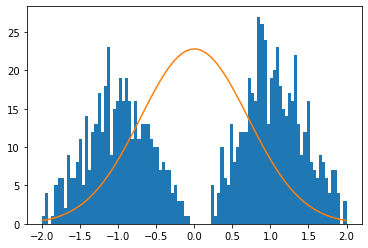

In [7]:
x_array = np.array(x_array)

bins = np.linspace(-2, 2, 100)
dx = bins[1] - bins[0]

plt.hist(x_array, bins=bins)
plt.plot(bins, 1000*dx/np.sqrt(np.pi)*np.exp(-bins**2))
plt.show()

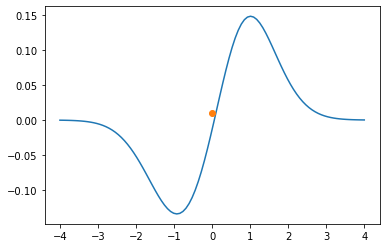

In [8]:
x_lin = torch.linspace(-4, 4, 100).reshape(100,-1)

model.resetHidden()
psi1 = model.forward_DNN(x_lin)[:,0].detach().numpy()

x = torch.Tensor([0])
model.forward_RNN(x)

#psi2 = model.forward_DNN(x_lin)[:,0].detach().numpy()


plt.plot(x_lin[:,0], psi1)
plt.plot(x, 0.01, "o")
#plt.plot(x_lin[:,0], psi2)

In [9]:
x = torch.Tensor([5]).requires_grad_()
y = torch.Tensor([5]).requires_grad_()

f = x**3 + y**3

dfdx, = torch.autograd.grad(f, x, create_graph=True)
print(dfdx)
ddfdxdx, = torch.autograd.grad(dfdx, x, create_graph=True)
print(ddfdxdx.grad_fn(x)[1])

tensor([75.], grad_fn=<MulBackward0>)
tensor([30.], grad_fn=<MulBackward0>)
